In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

# from skimage import data
from skimage import transform as tf
from skimage.transform import rotate

RESIZED_IMAGE_WIDTH = 20
RESIZED_IMAGE_HEIGHT = 30

classifications = np.loadtxt("classifications.txt") #, , fmt='%i')
flattened_images = np.loadtxt("flattened_images.txt")#,  fmt='%i')

In [10]:
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return itertools.zip_longest(*args, fillvalue=fillvalue)

We have a single sample for each digit, so we want to use warpping to produce more samples. To do that, we need the un-flattened images.

In [11]:
images = [ np.reshape(z, (RESIZED_IMAGE_HEIGHT, -1)) for z in flattened_images ]

In [12]:
def show_row(images, original=None):
    
    if original:
        extra = 1
    else:
        extra = 0
    
    fig, ax = plt.subplots(ncols=len(images)+extra, sharex=False, sharey=False)
    
    if original:
        ax[0].imshow(original, cmap=plt.cm.gray)
        ax[0].axis('off')
    
    for i in range(len(images)):
      ax[i+extra].imshow(images[i], cmap=plt.cm.gray)
      ax[i+extra].axis('off')
    
    plt.show()

In [13]:
def show_all(images):
    [ show_row(z) for z in grouper(images, 6, np.zeros(images[0].shape, dtype=np.int)) ];

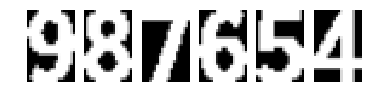

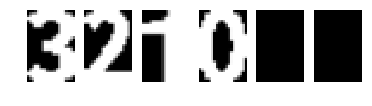

In [14]:
show_all(images)

Prep sample

In [15]:
MIN_CONTOUR_AREA = 100

RESIZED_IMAGE_WIDTH = 30
RESIZED_IMAGE_HEIGHT = 30
# font = cv2.FONT_HERSHEY_SIMPLEX
font = cv2.FONT_HERSHEY_COMPLEX_SMALL

def preprocess_score_image(original):
    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    _, bw_image = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    image = bw_image.copy()
    img_contours, npa_contours, npa_hierarchy = cv2.findContours(image,
                                                 cv2.RETR_EXTERNAL,
                                                 cv2.CHAIN_APPROX_SIMPLE)

    flattened_digits =  np.empty((0, RESIZED_IMAGE_WIDTH * RESIZED_IMAGE_HEIGHT), dtype=np.int)

    for i, npa_contour in enumerate(npa_contours):
        if cv2.contourArea(npa_contour) > MIN_CONTOUR_AREA:
            [intX, intY, intW, intH] = cv2.boundingRect(npa_contour)

            cv2.rectangle(original, (intX, intY), (intX+intW,intY+intH), (0, 0, 255), 2)
            imgROI = image[intY:intY+intH, intX:intX+intW]
            resized = cv2.resize(imgROI, (RESIZED_IMAGE_WIDTH, RESIZED_IMAGE_HEIGHT))
            flattened = resized.reshape((1, RESIZED_IMAGE_WIDTH * RESIZED_IMAGE_HEIGHT))
            flattened_images = np.append(flattened_images, flattened, 0)


    return classifications

In [17]:
import cv2

In [18]:
test_source = cv2.imread("samples\test_score.png")
test = preprocess_score_image(test_source)
print(test)

error: /io/opencv/modules/imgproc/src/color.cpp:11111: error: (-215) scn == 3 || scn == 4 in function cvtColor


In [ ]:
from sklearn import svm


In [ ]:
clf = svm.NuSVC()
clf.fit(X, Y)

Before applying any other transformations, let's add padding to serve as buffer for the results that will be off center

In [45]:
def padding(image, pixels=3):
    return np.lib.pad(image, (pixels,pixels), 'constant', constant_values=(0,0))

In [7]:
padded_iamges = [ padding(z) for z in images]

In [8]:
pd.set_option('max_rows', 55)
oneimage = pd.DataFrame(padded_iamges[0])
print(oneimage)

     0    1    2    3    4      5      6      7      8      9  ...      20  \
0   0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0    0.0    0.0 ...     0.0   
1   0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0    0.0    0.0 ...     0.0   
2   0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0    0.0    0.0 ...     0.0   
3   0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0    0.0    0.0 ...     0.0   
4   0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0    0.0    0.0 ...     0.0   
5   0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0    0.0   83.0 ...     0.0   
6   0.0  0.0  0.0  0.0  0.0    0.0    0.0    0.0   67.0  177.0 ...   140.0   
7   0.0  0.0  0.0  0.0  0.0    0.0    0.0   40.0  155.0  255.0 ...   255.0   
8   0.0  0.0  0.0  0.0  0.0    0.0    0.0  151.0  248.0  255.0 ...   255.0   
9   0.0  0.0  0.0  0.0  0.0    0.0  128.0  221.0  255.0  255.0 ...   255.0   
10  0.0  0.0  0.0  0.0  0.0    0.0  197.0  255.0  255.0  255.0 ...   255.0   
11  0.0  0.0  0.0  0.0  0.0   13.0  200.0  255.0  255.0  255.0 .

In [9]:
pd.reset_option('max_rows')

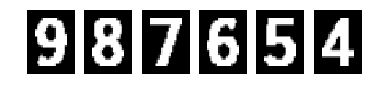

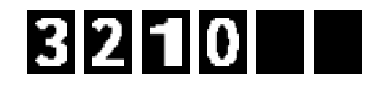

In [10]:
show_all(padded_iamges)

One of the warping procedures will be [rotating at the center](https://stackoverflow.com/questions/25895587/python-skimage-transform-affinetransform-rotation-center)

In [11]:
def center_rotate(image, degrees):
    shift_y, shift_x = np.array(image.shape[:2]) / 2. 
    # I guess the shape[:2] is to cut off a 3rd color dimension
    tf_rotate = tf.SimilarityTransform(rotation=np.deg2rad(degrees))
    tf_shift = tf.SimilarityTransform(translation=[-shift_x, -shift_y])
    tf_shift_inv = tf.SimilarityTransform(translation=[shift_x, shift_y])

    image_rotated = tf.warp(image, (tf_shift + (tf_rotate + tf_shift_inv)).inverse)
    # so it shifts the center of the image to the origin point, then rotates, and then
    # shifts back the center of the image to the center of the "canvas"
    # All the "transforms" are matrices - why exactly this arithmetic works ...
    return image_rotated
    
    

Apply different degree of transformation:

In [12]:
pad_n_rot = []
for i in padded_iamges:
   pad_n_rot += [ center_rotate(i, z) for z in range(-10,15,5) ]

Display the transformations

In [13]:
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return itertools.zip_longest(*args, fillvalue=fillvalue)

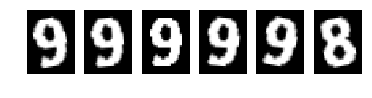

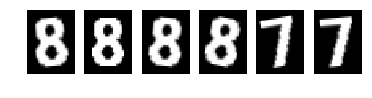

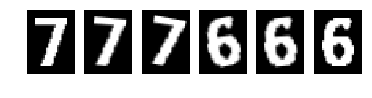

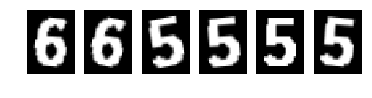

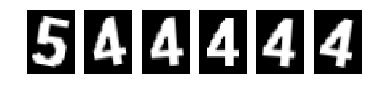

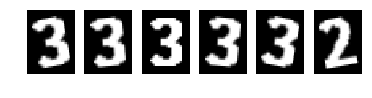

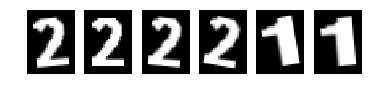

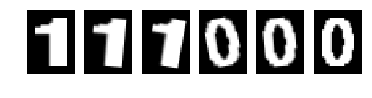

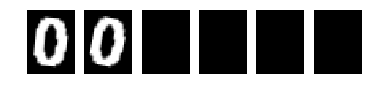

In [14]:
show_all(pad_n_rot)

In [42]:
def scale_up(image, pixels=3):
    resized = tf.resize(image,(image.shape[0]+pixels*2,image.shape[1]+pixels*2), mode='edge')
    return resized[pixels:-pixels, pixels:-pixels]

In [43]:
scaled = [ scale_up(z) for z in padded_iamges ]

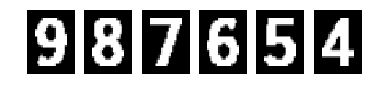

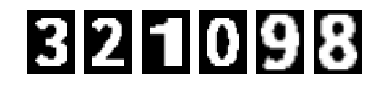

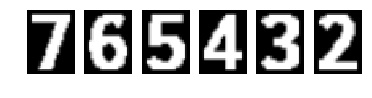

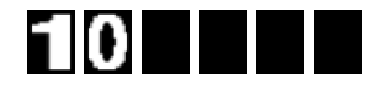

In [44]:
show_all(padded_iamges + scaled)

In [46]:
def scale_down(image, pixels=3):
    resized = tf.resize(image,(image.shape[0]+pixels*2,image.shape[1]+pixels*2), mode='edge')
    return padding(resized, pixels)

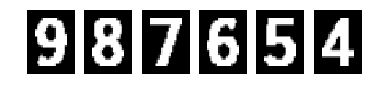

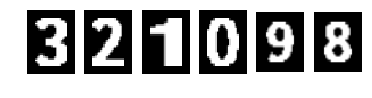

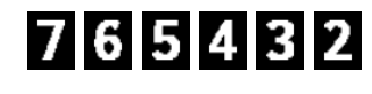

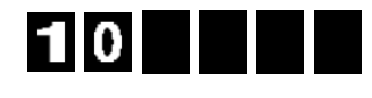

In [47]:
scaled = [ scale_down(z) for z in padded_iamges ]
show_all(padded_iamges + scaled)

In [20]:
oneimage.shape

(40, 30)

In [34]:
resized = tf.resize(oneimage,(46,36), mode='edge')
reform = resized[3:-3,3:-3]

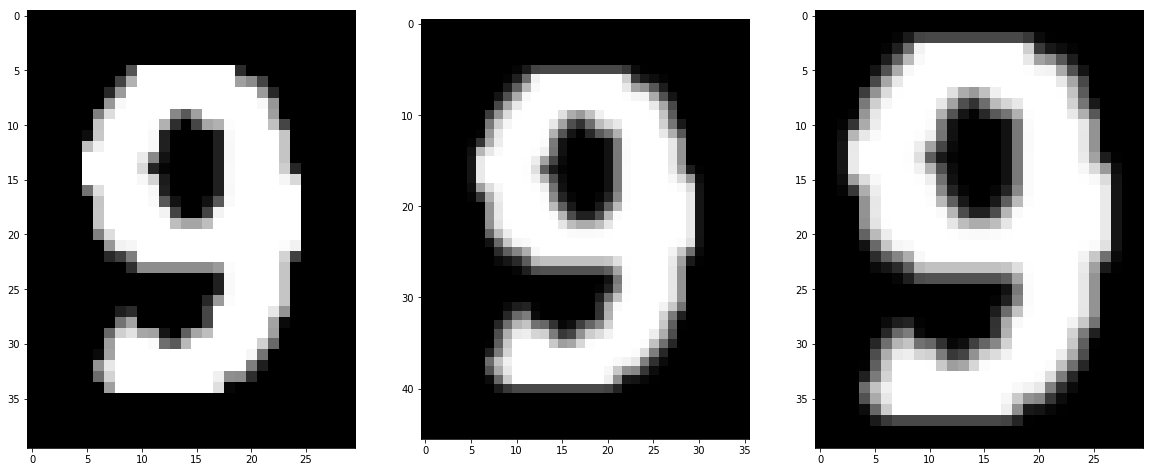

In [37]:
plt.figure(figsize=(20, 14));
ax = plt.subplot(1, 3, 1);
plt.imshow(oneimage);
plt.gray()
ax = plt.subplot(1, 3, 2);
plt.imshow(resized);
plt.gray()
ax = plt.subplot(1, 3, 3);
plt.imshow(reform);
plt.gray()

In [23]:
[ print(z.shape) for z in [oneimage, resized]]

(40, 30)
(46, 36)


[None, None]

Another transformation will be translation